In [1]:
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path
from matplotlib import patches
import pandas as pd
from utils.find_errors import *
from PIL import Image
from utils.dataset_creation import load_dataset, get_utils_variables

In [2]:
DATA_PATH = Path('./dataset')
images_df, targets_df = load_dataset(DATA_PATH)
images_path, id2label = get_utils_variables(DATA_PATH)
preds_df = pd.read_csv('preds')

In [3]:
errors_df = classify_predictions_errors(targets_df, preds_df)

Classify errors: 100%|███████████████████| 26476/26476 [00:50<00:00, 529.22it/s]


In [4]:
def display_image_with_bboxes(ax, image_id, images_df, images_path, bbox_df=None, id2label=None):
    image_filename = images_df.query("image_id == @image_id").iloc[0]["file_name"]
    image = Image.open(images_path / image_filename).convert("RGB")

    ax.imshow(image)
    ax.axis("off")
    if bbox_df is not None:
        bboxes = bbox_df.query("image_id == @image_id")[["xmin", "ymin", "xmax", "ymax"]].values
        labels = bbox_df.query("image_id == @image_id")["label_id"].values
        for i in range(bboxes.shape[0]):
            bbox = bboxes[i, :]
            bot_left = (bbox[0], bbox[1])
            width = bbox[2] - bbox[0]
            height = bbox[3] - bbox[1]

            if id2label is not None:
                label = id2label.get(labels[i], "unknown")
                ax.text(
                    bbox[0]+2,
                    bbox[1]-2,
                    label,
                    color="white",
                    verticalalignment="bottom",
                    horizontalalignment="left",
                    fontsize="medium",
                    fontweight="bold",
                    bbox=dict(facecolor="black", edgecolor=None),
                    zorder=1
                )

                outer_box = patches.Rectangle(
                    bot_left, width, height, linewidth=4, edgecolor="black", fill=False, zorder=2
                )
                inner_box = patches.Rectangle(
                    bot_left, width, height, linewidth=2, edgecolor="white", fill=False, zorder=3
                )
                
                ax.add_patch(outer_box)
                ax.add_patch(inner_box)

Для демонстрации работы программы был выбран набор данных **Udacity self driving car dataset** и модель для обнаружения объектов **yolov8s** c основными параметрами: *epochs=20, conf=0.1,* а также размер обучающей выборки составил 70% от общего количества данных. Все данные были стратифицированы по находящимся на изображении классам.

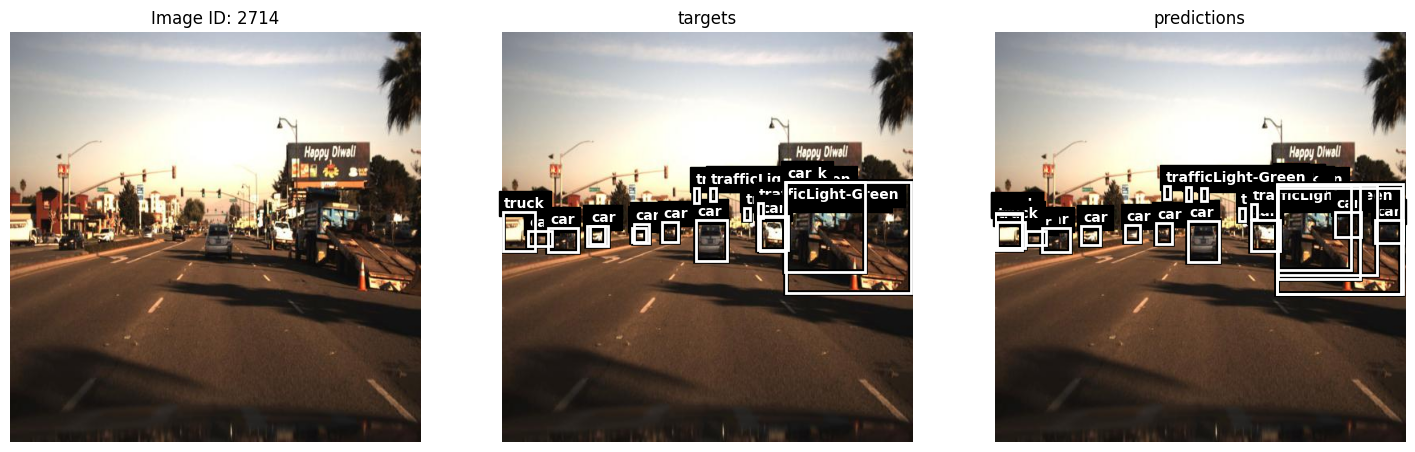

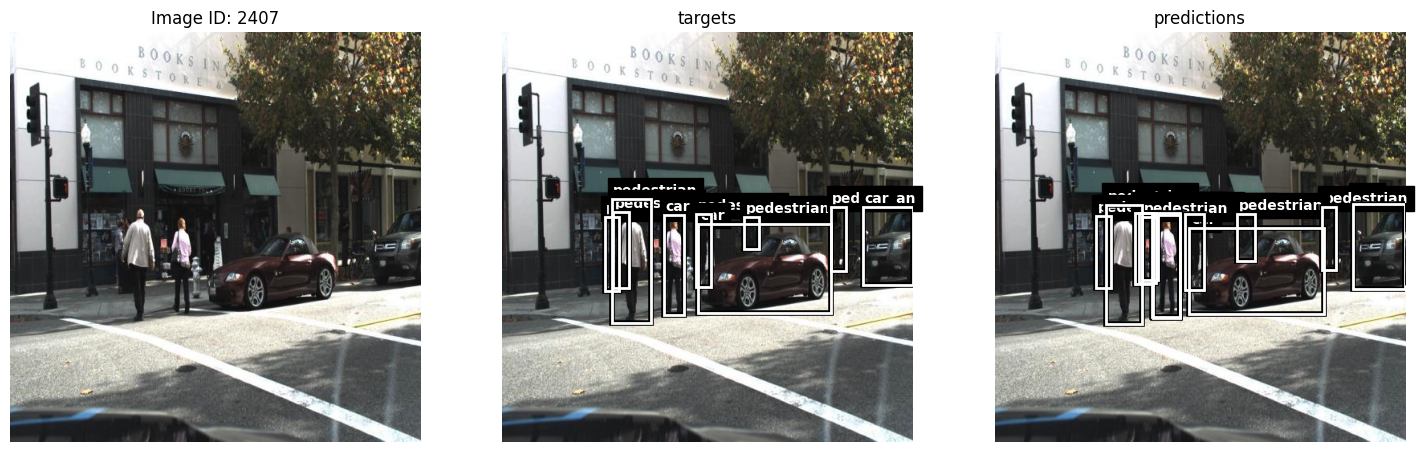

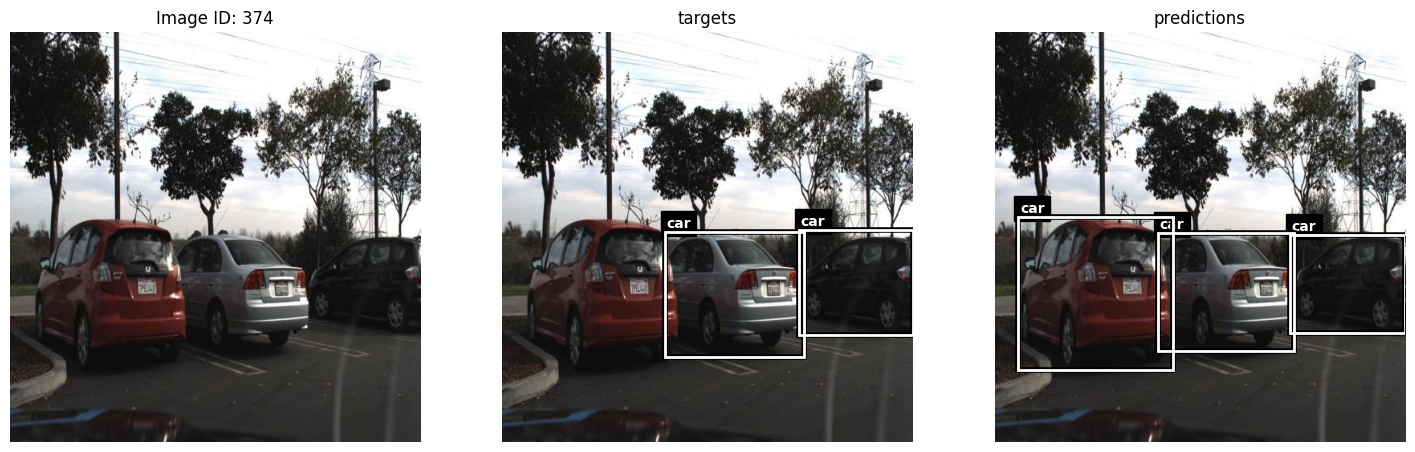

In [5]:
image_ids = [2714, 2407, 374]
for image_id in image_ids:
    plt.figure(figsize=(18,6))
    ax = plt.subplot(131)
    display_image_with_bboxes(ax, image_id, images_df, images_path, id2label=id2label);
    plt.title(f"Image ID: {image_id}")
    ax = plt.subplot(132)
    display_image_with_bboxes(ax, image_id, images_df, images_path, targets_df, id2label);
    plt.title("targets")
    ax = plt.subplot(133)
    display_image_with_bboxes(ax, image_id, images_df, images_path, preds_df, id2label);
    plt.title("predictions")

Явно видно ошибку в виде отсутствия аннотации на последнем образце. Ошибка помечена как **background**, т.е считается, что модель определила фон как передний план. Что же касается первых двух образцов, то сложно сказать, что они содержат ошибки. Давайте исследуем их подробнее.

In [6]:
first_img_preds = preds_df.query('image_id==2714')
first_pred_list = list(first_img_preds['pred_id'])
first_errors = errors_df.query('pred_id in @first_pred_list')
first_pred_ids = list(first_errors[first_errors['error_type']=='localization']['pred_id'])
first_tar_ids = list(first_errors[first_errors['error_type']=='localization']['target_id'])
first_preds = preds_df.query('pred_id in @first_pred_ids')
first_targs = targets_df.query('target_id in @first_tar_ids')

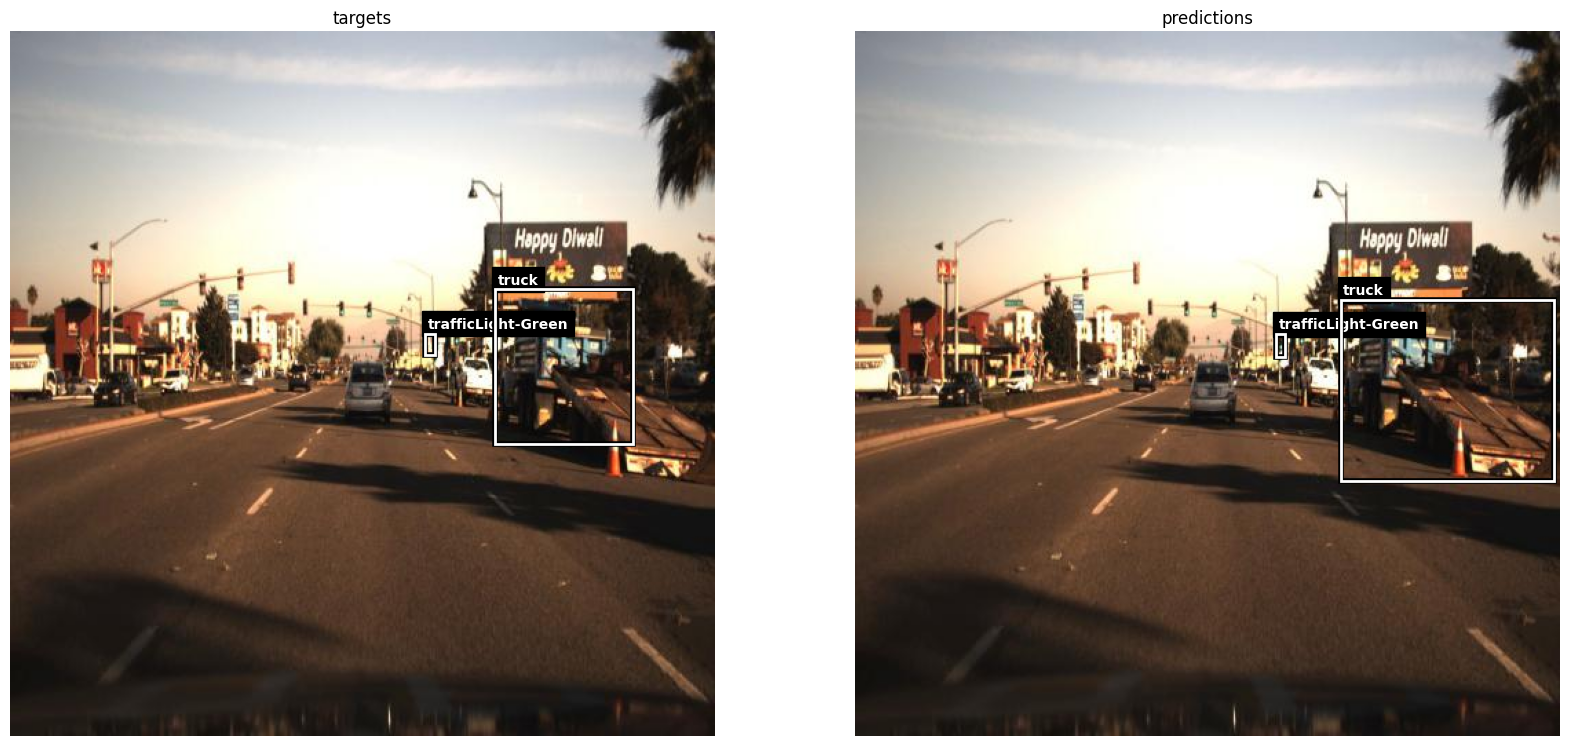

In [7]:
image_ids = [2714]
for image_id in image_ids:
    plt.figure(figsize=(20,15))
    ax = plt.subplot(121)
    display_image_with_bboxes(ax, image_id, images_df, images_path, first_targs, id2label);
    plt.title("targets")
    ax = plt.subplot(122)
    display_image_with_bboxes(ax, image_id, images_df, images_path, first_preds, id2label);
    plt.title("predictions")

Если присмотреться, то видно, что светофор размечен неверно. Разметку грузовика можно трактовать по разному:
- правильная, если в контексте не учитывается рядом стоящая отцепленная платформа
- неправильная, если в контексте учитывается рядом стоящая часть транспортного средства (например, в автопилотировании)

In [8]:
second_img_preds = preds_df.query('image_id==2407')
second_pred_list = list(second_img_preds['pred_id'])
second_errors = errors_df.query('pred_id in @second_pred_list')
second_pred_ids = list(second_errors[second_errors['error_type']=='classification']['pred_id'])
second_tar_ids = list(second_errors[second_errors['error_type']=='classification']['target_id'])
second_preds = preds_df.query('pred_id in @second_pred_ids')
second_targs = targets_df.query('target_id in @second_tar_ids')

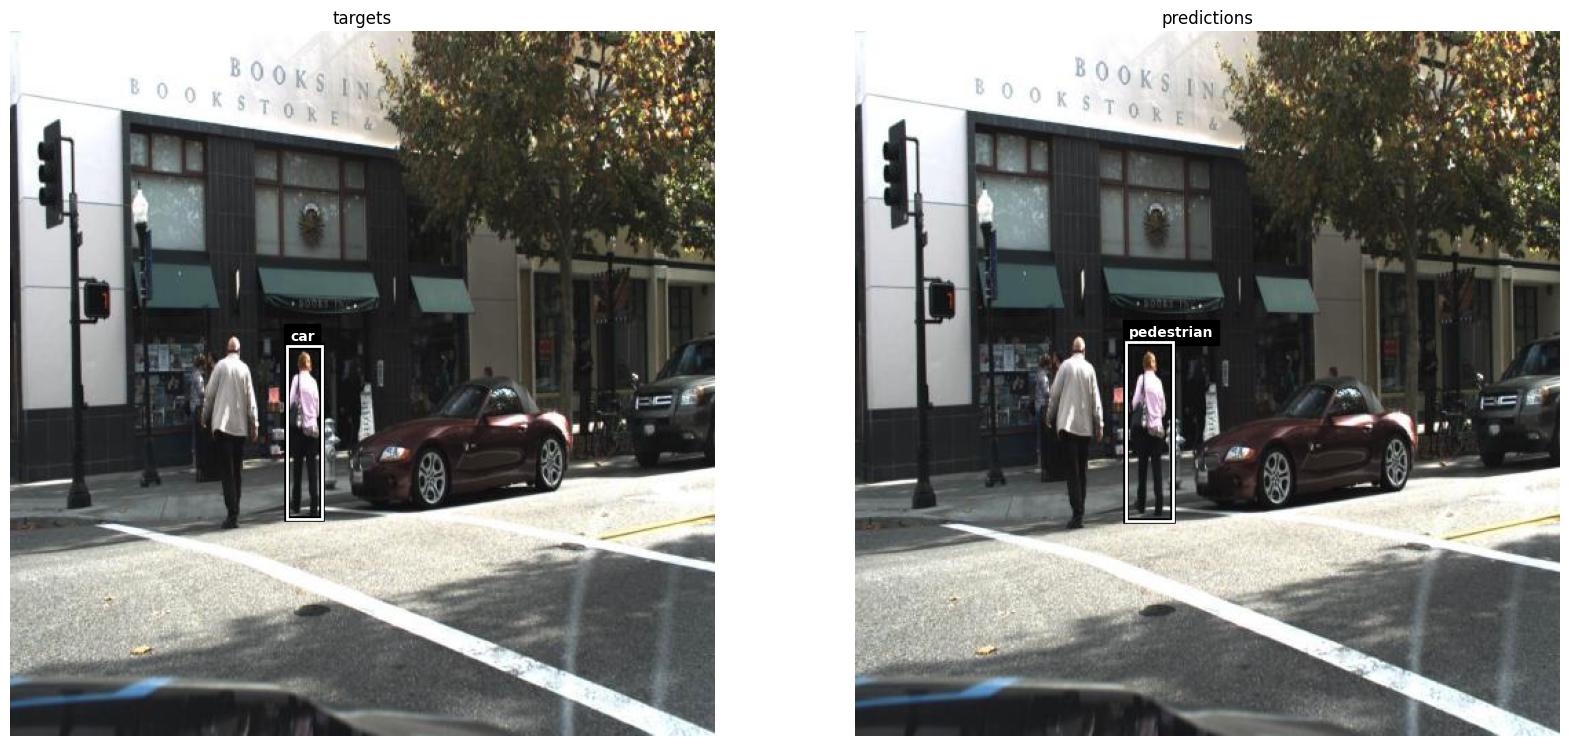

In [9]:
image_ids = [2407]
for image_id in image_ids:
    plt.figure(figsize=(20,15))
    ax = plt.subplot(121)
    display_image_with_bboxes(ax, image_id, images_df, images_path, second_targs, id2label);
    plt.title("targets")
    ax = plt.subplot(122)
    display_image_with_bboxes(ax, image_id, images_df, images_path, second_preds, id2label);
    plt.title("predictions")

После очистки видно в чем заключается ошибка классификации.